In [ ]:
!pip install opendatasets

In [ ]:
'''!pip install lime'''

## 📥 Download Apple Disease Dataset from Kaggle


In [ ]:

import opendatasets as od
od.download("https://www.kaggle.com/datasets/ludehsar/apple-disease-dataset")

Skipping, found downloaded files in "./apple-disease-dataset" (use force=True to force download)


## 📦 Import Libraries and Modules for Apple Disease Classification




In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers

from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Conv2D
from tensorflow.keras.preprocessing import image_dataset_from_directory, image


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

## 🗂️ Explore Dataset Structure

### ➤ Count Number of Images per Category in Test Folder


In [ ]:
data_dir = '/content/apple-disease-dataset/datasets/test'
categories = os.listdir(data_dir)

for category in categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        count = len([img for img in os.listdir(category_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))])
        print(f"{category}: {count} images")

healthy: 502 images
apple_scab: 504 images
black_rot: 497 images
cedar_apple_rust: 440 images


### ➤ Count Number of Images per Category in Train Folder


In [ ]:
dataset_path = '/content/apple-disease-dataset/datasets/train'
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    # Count image files with common extensions
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Number of {cls} images : {len(image_files)} images")

Number of healthy images : 2008 images
Number of apple_scab images : 2016 images
Number of black_rot images : 1987 images
Number of cedar_apple_rust images : 1760 images


# Total Images in Train  Dataset

In [ ]:
total_images = 0
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    total_images += len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print(f"\nTotal images in train dataset is : {total_images}")


Total images in train dataset is : 7771


## 🧪 Train-Test Datasets

### ➤ Create Training and Validation Datasets from Train Dataset.
### ➤ Test Dataset is available.


In [ ]:
base_dir_train = '/content/apple-disease-dataset/datasets/train'

train_dataset = image_dataset_from_directory(
    base_dir_train,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size =(224,224),
    labels = 'inferred',
    batch_size = 32,
    color_mode = 'rgb',
    shuffle=True

)
base_dir_test = '/content/apple-disease-dataset/datasets/train'
valid_dataset = image_dataset_from_directory(
    base_dir_test,
    validation_split=0.2,
    subset='validation',
    image_size = (224,224),
    batch_size= 32,
    seed=42,
    color_mode='rgb',
    shuffle=True,

)
base_dir_test = '/content/apple-disease-dataset/datasets/test'

test_dataset = image_dataset_from_directory(
    base_dir_test,
    image_size=(224, 224),
    labels = 'inferred',
    batch_size=32,
    color_mode='rgb',
    shuffle=False  # Don't shuffle for consistent evaluation
)

print("\nTrain classes:", train_dataset.class_names)
print("\nTest classes:", test_dataset.class_names)


Found 7771 files belonging to 4 classes.
Using 6217 files for training.
Found 7771 files belonging to 4 classes.
Using 1554 files for validation.
Found 1943 files belonging to 4 classes.

Train classes: ['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']

Test classes: ['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']


### Visualize Images form test dataset

In [ ]:
'''for images, labels in test_dataset.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.show()
'''

'for images, labels in test_dataset.take(1):\n    for i in range(5):\n        plt.imshow(images[i].numpy().astype("uint8"))\n        plt.title(f"Label: {labels[i].numpy()}")\n        plt.show()\n'

 ## 🧼 Data Preprocessing
 ### Normalization


In [ ]:
normalize_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y : (normalize_layer(x),y))
valid_dataset = valid_dataset.map(lambda x, y: (normalize_layer(x),y))

test_dataset = test_dataset.map(lambda x, y: (normalize_layer(x), y))




## 🎨 Data Augmentation




In [ ]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal and vertical'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Apply augmentation to training dataset
augmented_train_ds = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    patience =3,
    verbose=0,
    monitor='val_accuracy',
    start_from_epoch =4,
    mode = 'max'
)

## 🏗️ Build the CNN Model Architecture

### ➤ Define the Sequential Convolutional Neural Network (CNN)


In [ ]:
# Building the Model Architecture
'''model = Sequential()

# Input Conv Layer
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))

# Intermediate Conv Layers
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(120, activation='relu'))

# Output Layer (4 classes)
model.add(Dense(4, activation='softmax'))

model.summary()'''



"model = Sequential()\n\n# Input Conv Layer\nmodel.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)))\nmodel.add(MaxPool2D(2,2))\n\n# Intermediate Conv Layers\nmodel.add(Conv2D(64, (3,3), activation='relu', padding='same'))\nmodel.add(MaxPool2D(2,2))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(64, (3,3), activation='relu', padding='same'))\nmodel.add(MaxPool2D(2,2))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(128, (3,3), activation='relu', padding='same'))\nmodel.add(MaxPool2D(2,2))\n\n# Flatten and Dense Layers\nmodel.add(Flatten())\nmodel.add(Dense(120, activation='relu'))\n\n# Output Layer (4 classes)\nmodel.add(Dense(4, activation='softmax'))\n\nmodel.summary()"

In [ ]:
'''import numpy as np

# Define your model as you did
model = tf.keras.models.Sequential([
    layers.Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu',name='third'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', name='last_layer'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(324, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation='softmax')
])

dummy_input = np.zeros((1, 224, 224, 3), dtype=np.float32)
_ = model(dummy_input)  # This will build the model properly


# Now you can call model.summary()
model.summary()
'''

"import numpy as np\n\n# Define your model as you did\nmodel = tf.keras.models.Sequential([\n    layers.Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)),\n    layers.MaxPooling2D((2,2)),\n\n    layers.Conv2D(128, (3,3), activation='relu'),\n    layers.MaxPooling2D((2,2)),\n\n    layers.Conv2D(256, (3,3), activation='relu',name='third'),\n    layers.MaxPooling2D((2,2)),\n\n    layers.Conv2D(256, (3,3), activation='relu'),\n    layers.MaxPooling2D((2,2)),\n\n    layers.Conv2D(256, (3,3), activation='relu', name='last_layer'),\n    layers.MaxPooling2D((2,2)),\n\n    layers.Flatten(),\n    layers.Dense(128, activation='relu'),\n    layers.Dense(128, activation='relu'),\n    layers.Dense(256, activation='relu'),\n    layers.Dense(324, activation='relu'),\n    layers.Dropout(0.1),\n    layers.Dense(4, activation='softmax')\n])\n\ndummy_input = np.zeros((1, 224, 224, 3), dtype=np.float32)\n_ = model(dummy_input)  # This will build the model properly\n\n\n# Now you ca

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(128, (3,3), activation='relu',name='first')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu',name='second')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation='relu',name='third')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation='relu',name='forth')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation='relu', name='last_layer')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(324, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model
model = build_model()

## 🧠 Compile the Model

### ➤ Set Optimizer, Loss Function, and Evaluation Metrics


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    augmented_train_ds,               # Your augmented training dataset
    epochs=20,                        # Number of training epochs
    callbacks=[callback],             # Callbacks (e.g., EarlyStopping, ModelCheckpoint)
    validation_data=valid_dataset      # Validation dataset to monitor performance
)


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 114s 489ms/step - accuracy: 0.3539 - loss: 1.3341 - val_accuracy: 0.6718 - val_loss: 0.9122
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 113s 414ms/step - accuracy: 0.6993 - loss: 0.7390 - val_accuracy: 0.8481 - val_loss: 0.3716
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 448ms/step - accuracy: 0.8841 - loss: 0.3159 - val_accuracy: 0.8790 - val_loss: 0.3313
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 455ms/step - accuracy: 0.9256 - loss: 0.2002 - val_accuracy: 0.9163 - val_loss: 0.2229
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 442ms/step - accuracy: 0.9512 - loss: 0.1503 - val_accuracy: 0.9080 - val_loss: 0.2547
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 446ms/step - accuracy: 0.9525 - loss: 0.1395 - val_accuracy: 0.9691 - val_loss: 0.0880
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 438ms/step - accuracy: 0.9757 - loss: 0.0656 - val_accuracy: 0.9434 - val_loss: 0.1913
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 440ms/step - accuracy: 0.9621 - loss

In [ ]:
model.save_weights('model.weights.h5')
model.load_weights('model.weights.h5')  # works fine

# Now model.input and model.output are available
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[model.get_layer("third").output, model.output]
)



In [ ]:

def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize if your model was trained this way
    return img_array

img_path = "/content/healthy.JPG"  # Replace with your image
preprocessed_img = preprocess_image(img_path)



In [ ]:
last_conv_layer_name = "third"

grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)



In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(preprocessed_img)
    class_idx = tf.argmax(predictions[0])
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


/tmp/ipython-input-1050552184.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("jet")


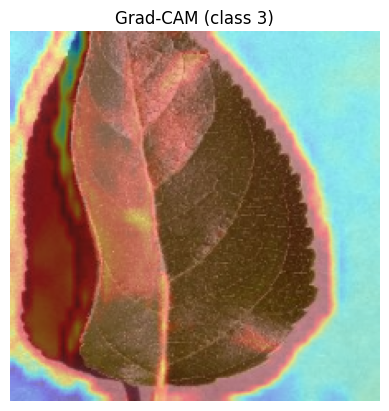

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

import cv2
# Load original image (again for display)
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

colormap = cm.get_cmap("jet")
colored_heatmap = colormap(heatmap)
colored_heatmap = np.delete(colored_heatmap, 3, 2)  # remove alpha
colored_heatmap = np.uint8(255 * colored_heatmap)

superimposed_img = cv2.addWeighted(img, 0.6, colored_heatmap, 0.4, 0)

# Show result
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Grad-CAM (class {class_idx.numpy()})")
plt.show()


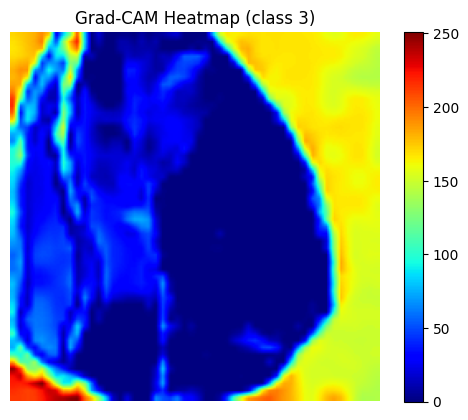

Predicted class: 3


In [ ]:
import matplotlib.pyplot as plt

# Resize if needed (optional if already resized before)
heatmap = cv2.resize(heatmap, (224, 224))

# Display the heatmap using matplotlib
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title(f"Grad-CAM Heatmap (class {class_idx.numpy()})")
plt.colorbar()
plt.show()
predicted_class = tf.argmax(predictions[0]).numpy()
print(f"Predicted class: {predicted_class}")


## 📈 Visualize Training Performance with Matplotlib

### ➤ Detailed Accuracy and Loss Curves with Labels and Grid


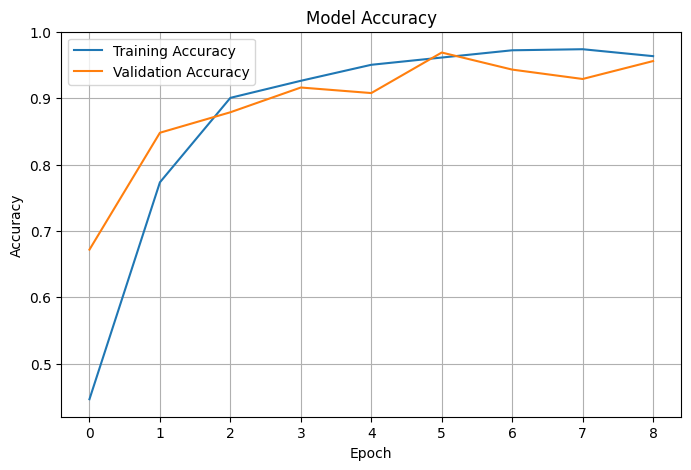

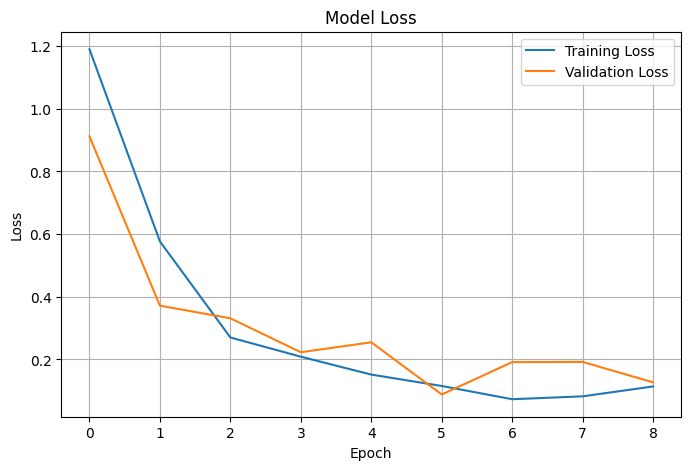

In [ ]:

# Convert training history to DataFrame
history_dir = pd.DataFrame(history.history)

# Plot Accuracy
plt.figure(figsize=(8, 5))
history_dir.loc[:, ['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
history_dir.loc[:, ['loss', 'val_loss']].plot(ax=plt.gca())
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid(True)
plt.show()


## 📊 Evaluate the Model on Test Dataset

### ➤ Calculate and Display Test Loss and Accuracy


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Accuracy of our model: {test_accuracy:.2f}, Test Loss of our model: {test_loss:.3f}')


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9245 - loss: 0.2102
Accuracy of our model: 0.96, Test Loss of our model: 0.117


## 📊 Model Evaluation: Test Dataset Classification Report & Confusion Matrix

This section evaluates the overall performance of the apple leaf disease classifier on the test dataset.


## Step 1: Predict on the test dataset
We run the model on the test dataset and collect true and predicted labels.

In [ ]:
 #--- Class labels in the correct order ---
class_names = ['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']

# --- Initialize true and predicted labels ---
y_true = []
y_pred = []

# --- Predict on each batch in the test dataset ---
for images, labels in test_dataset:
    preds = model.predict(images)                      # Softmax outputs
    y_true.extend(labels.numpy())                      # True labels
    y_pred.extend(np.argmax(preds, axis=1))            # Predicted labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1

## Step 2: Calculate accuracy
Compute overall accuracy on the test set.

In [ ]:
from sklearn.metrics import accuracy_score

# --- Accuracy ---
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")



✅ Accuracy: 0.9624


## Step 3: Generate classification report
Calculate precision, recall, f1-score, and support per class.

In [ ]:
# --- Classification Report as DataFrame ---
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()


## Step 4: Calculate specificity
Compute specificity per class from the confusion matrix and add it to the report.

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

# --- Specificity Calculation ---
specificity = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # True Negatives
    fp = np.sum(np.delete(cm[:, i], i))                          # False Positives
    spec = tn / (tn + fp)
    specificity.append(spec)

# --- Add Specificity to Report DataFrame ---
for i, cls in enumerate(class_names):
    report_df.loc[cls, 'specificity'] = specificity[i]

# --- Round values for clean display ---
report_df = report_df.round(3)


## Step 5: Display enhanced classification report
Show the classification report including specificity.

In [ ]:
print("\n📋 Enhanced Classification Report (with Specificity):\n")
print(report_df[['precision', 'recall', 'f1-score', 'support', 'specificity']])



📋 Enhanced Classification Report (with Specificity):

                  precision  recall  f1-score   support  specificity
apple_scab            0.982   0.883     0.930   504.000        0.994
black_rot             0.984   0.988     0.986   497.000        0.994
cedar_apple_rust      0.977   0.984     0.981   440.000        0.993
healthy               0.914   0.998     0.954   502.000        0.967
accuracy              0.962   0.962     0.962     0.962          NaN
macro avg             0.964   0.963     0.963  1943.000          NaN
weighted avg          0.964   0.962     0.962  1943.000          NaN



## Step 6: Visualize confusion matrix
Plot the confusion matrix heatmap to visualize predictions.

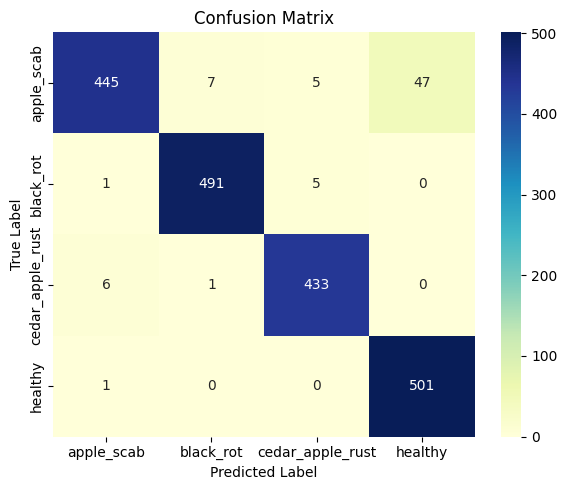

In [ ]:
# --- Plot the Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


## 🖼️ Single Image Prediction: Apple Leaf Disease Classifier

This section demonstrates how to make a prediction for a single apple leaf image using the trained CNN model.


## Step 1: Define a function to load and preprocess the image


In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)     # Load image
    img_array = img_to_array(img)                           # Convert to numpy array
    img_array = img_array / 255.0                           # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)           # Add batch dimension
    return img_array


## Step 2: Set the image path and class names


In [ ]:
image_path = "/content/healthy.JPG"
class_names = ['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']  # Define class labels


## Step 3: Load and preprocess the image

In [ ]:
img = load_and_preprocess_image(image_path)


## Step 4: Predict the class of the image using the model

In [ ]:
predictions = model.predict(img)
predicted_class_idx = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_idx]
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Predicted class: healthy


## Step 5: Display the image with the predicted label

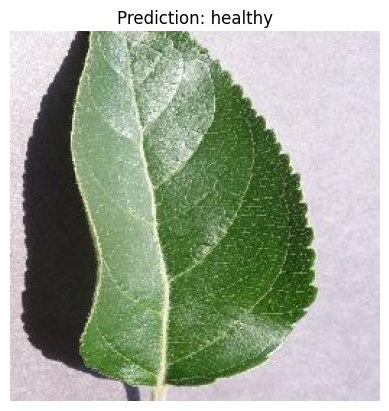

In [ ]:
original_img = load_img(image_path)
plt.imshow(original_img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')
plt.show()


#Grad CAM

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image
def load_image(path, size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(path, target_size=size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # normalize like training
    return np.expand_dims(img_array, axis=0)  # shape: (1, h, w, 3)


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of class output w.r.t. conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean gradient for each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by corresponding gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def overlay_heatmap(heatmap, original_image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap_rescaled = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_rescaled, colormap)

    # Convert original image from RGB to BGR (for OpenCV)
    original_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

    overlayed = cv2.addWeighted(heatmap_colored, alpha, original_bgr, 1 - alpha, 0)
    return cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB)  # convert back to RGB


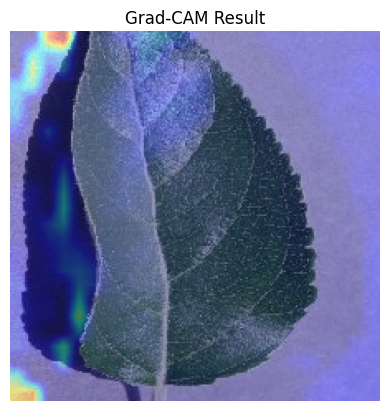

In [ ]:

# Load and preprocess the image
img_path = '/content/healthy.JPG'
img_array = load_image(img_path)

# Get the raw image (without batch dimension) for visualization
raw_img = tf.keras.preprocessing.image.img_to_array(
    tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
).astype("uint8")

# Identify the last conv layer (adjust this name if needed)
last_conv_layer_name = "forth"  # Example for ResNet50

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Overlay it
overlayed_img = overlay_heatmap(heatmap, raw_img)

# Show result
plt.imshow(overlayed_img)
plt.axis('off')
plt.title("Grad-CAM Result")
plt.show()
